<h1 align='center'>Time-Series Analysis on TATA Steel</h1>
<h3 align='center'>Analyze the Data and Predict the Price of the Stock till January</h3>

### Import Initial Packages

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#### OBJECTIVES:
1. Data Cleaning 
    - Convert to Date-Time Format
    - Remove unnecessary values (If any)
2. Split the Data into Train and Test 
3. Visualize the Data
4. Feature Scaling
    - Obtain the Independent and Dependent Data
5. Build the Model
    - Stacked-LSTM
6. Future Predictions
7. Model Evaluation
8. Forecast the Future Values  (With the Training Data - TimeStep= 30)
9. Forecast the Future Values  (With the Full Data - TimeStep= 30)
10. Forecast the Future Values  (With the Full Data - TimeStep)
11. Combining the Data

#### END-GOAL:
<strong>Predict the Number of Onboarding Cliets till February 2022 end</strong>

### Loading the Required Data

In [2]:
### Load and View the Data
df = pd.read_csv('TATASTEEL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,645.0,649.700012,640.000000,643.099976,629.023438,8411396
1,2021-01-04,649.0,699.900024,646.450012,693.000000,677.831238,38184955
2,2021-01-05,687.0,693.849976,675.099976,680.549988,665.653748,21545254
3,2021-01-06,684.0,696.650024,675.000000,683.799988,668.832581,19610522
4,2021-01-07,693.0,731.500000,691.700012,722.799988,706.978943,38232194


### Data Cleaning

In [3]:
### Understanding the Data Type
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

- We can see that the **Date** Column is of type *'object'*. We will convert them to DateTime format.

In [4]:
### Converting the 'Date' Column to datetime format. 

df['Date']=pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,645.0,649.700012,640.000000,643.099976,629.023438,8411396
1,2021-01-04,649.0,699.900024,646.450012,693.000000,677.831238,38184955
2,2021-01-05,687.0,693.849976,675.099976,680.549988,665.653748,21545254
3,2021-01-06,684.0,696.650024,675.000000,683.799988,668.832581,19610522
4,2021-01-07,693.0,731.500000,691.700012,722.799988,706.978943,38232194


In [5]:
## Resetting the Index.
df_Close = df.copy()

df_Close = df_Close[['Date','Close']]
df_Close.head()

,Date,Close
0,2021-01-01,643.099976
1,2021-01-04,693.000000
2,2021-01-05,680.549988
3,2021-01-06,683.799988
4,2021-01-07,722.799988


In [6]:
## Checking for Null Values
df_Close.isnull().any()

Date     False
Close    False
dtype: bool

> Since there are no missing values we can go ahead with the further analysis.

In [7]:
len(df_Close)

239

### Splitting the Dataset into Train and Test Data

- In case of Time Series Data we will divide the data with respect to Date. This division is done so that we understand how well our Data is Forecasting.

In [8]:
## Train and Test Data
train_size = int(len(df_Close)*0.70)    ## Taking 70% of the Data as Train size.
test_size = len(df_Close)-train_size    ## 30% Test size.

train_data, test_data = df_Close.iloc[0:train_size], df_Close.iloc[train_size:len(df_Close)]      ## Obtaining Train and Test Data.

In [9]:
train_data.tail()

,Date,Close
162,2021-08-30,1440.599976
163,2021-08-31,1450.250000
164,2021-09-01,1411.199951
165,2021-09-02,1425.099976
166,2021-09-03,1443.650024


- From here we can see that the train data is till 3rd September 2021.

### Visualize the Time Serie Data.

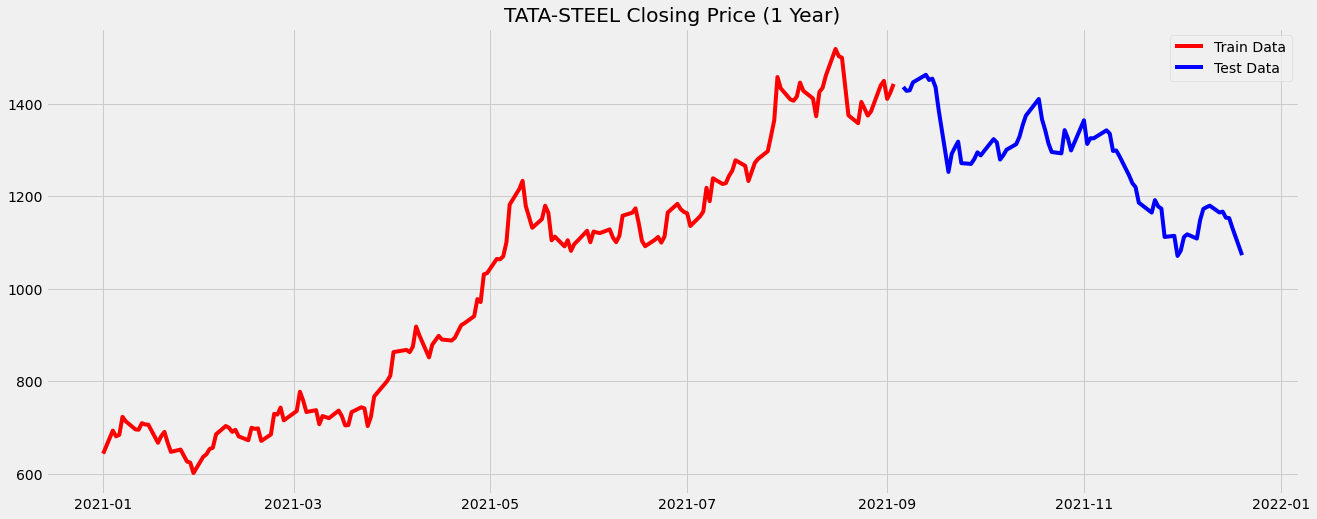

In [10]:
# Visualizing the Onboardings
plt.figure(figsize=(20,8))
plt.plot(train_data.set_index('Date'), label='Train Data', color='red')
plt.plot(test_data.set_index('Date'), label='Test Data', color='blue')
plt.title('TATA-STEEL Closing Price (1 Year)')
plt.legend()
plt.show()

- We can see that for this particular Year (2021) we get a somewhat a decreasing trend towards the end of the plot. 

### Understanding the Different Components

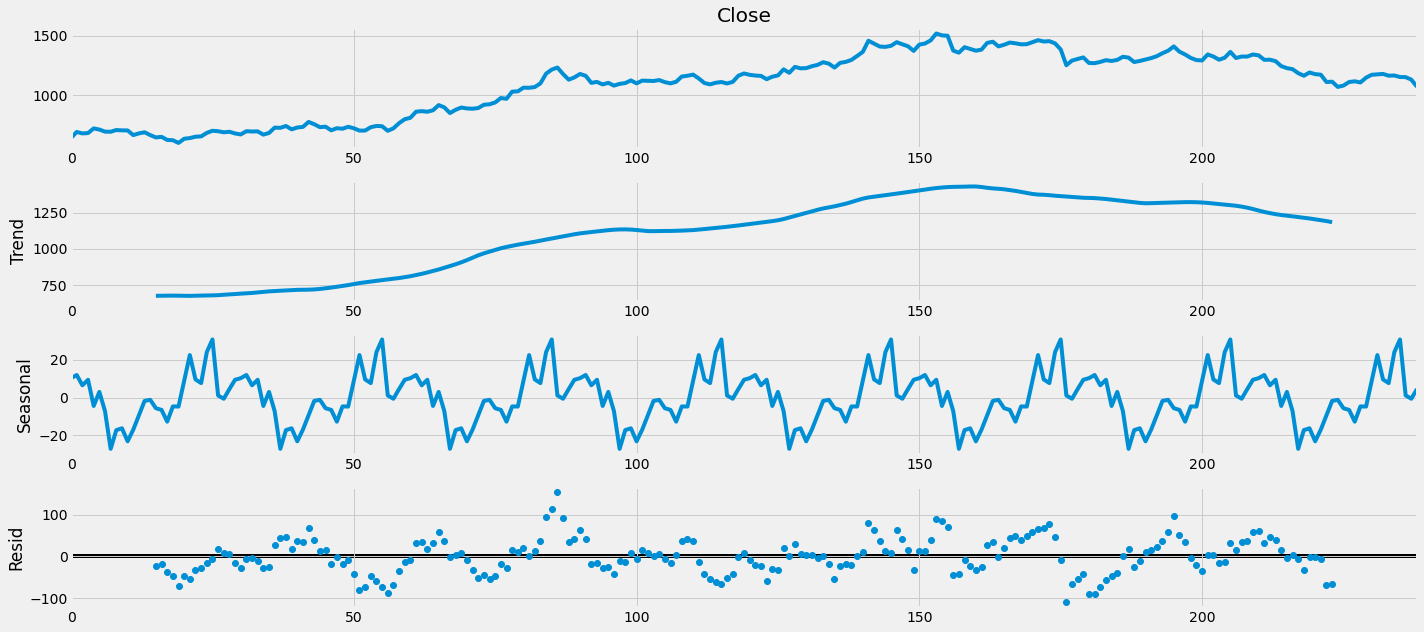

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_Close['Close'], freq = 30)

plt.rcParams.update({'figure.figsize': (20,9)})
decomposition.plot()
plt.show()

**TERMINOLOGIES**

- Observed: The Original Time Series Plot.
- Trend: This is obtained by isolating any of the Seasonality in the Data.
- Seasonal: This is obtained by isolating any of the Trend in the Data.
- Resid: What cant be explained by the Trend and Seasonality Plots (Basically the Noise)

### Data Preprocessing 

#### Feature Scaling

In [12]:
## Resetting the Index and Selecting only the Closing Price Column.
train_data = train_data.reset_index()['Close']
test_data = test_data.reset_index()['Close']
train_data.head()

0    643.099976
1    693.000000
2    680.549988
3    683.799988
4    722.799988
Name: Close, dtype: float64

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))     ## Setting the range of values to be scaled between 0 and 1.

train_data = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data = scaler.fit_transform(np.array(test_data).reshape(-1,1))

print(train_data)

[[0.04584057]
 [0.10017421]
 [0.08661802]
 [0.09015678]
 [0.13262193]
 [0.12211457]
 [0.10305969]
 [0.10224305]
 [0.11775917]
 [0.11471034]
 [0.11422041]
 [0.07153747]
 [0.08721687]
 [0.09707102]
 [0.07153747]
 [0.05008711]
 [0.05547693]
 [0.02722125]
 [0.02471691]
 [0.        ]
 [0.03821861]
 [0.04426178]
 [0.05678356]
 [0.05983233]
 [0.09151784]
 [0.11100829]
 [0.1069251 ]
 [0.09717988]
 [0.10202527]
 [0.08656359]
 [0.07747171]
 [0.1069251 ]
 [0.10431183]
 [0.10534625]
 [0.07589287]
 [0.09097342]
 [0.13969946]
 [0.13795733]
 [0.15450786]
 [0.12429227]
 [0.14089723]
 [0.14645034]
 [0.19180098]
 [0.17089504]
 [0.14405486]
 [0.14835583]
 [0.1151459 ]
 [0.13447299]
 [0.12951874]
 [0.14743034]
 [0.133983  ]
 [0.11258713]
 [0.11307706]
 [0.14372822]
 [0.15516115]
 [0.15260237]
 [0.11084493]
 [0.13300307]
 [0.18058577]
 [0.21668118]
 [0.22958403]
 [0.28533317]
 [0.29045078]
 [0.28511538]
 [0.29818159]
 [0.34560106]
 [0.32502177]
 [0.27281139]
 [0.30270034]
 [0.32360628]
 [0.3149499 ]
 [0.31

#### Obtaining Independent and Dependent Features

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

## Converting to Independent and Dependent Features (based on TimeSteps)
def get_data(dataset, timestep= 1):
    Xdata, ydata = [], []
    for i in range(len(dataset) - timestep - 1):
        generator = TimeseriesGenerator(dataset, dataset, length=timestep, batch_size= 1)
        X,y = generator[i]
        Xdata.append(X.flatten())
        ydata.append(y.flatten()[0])  ## Here we will obtain our Output.
    return np.array(Xdata), np.array(ydata)

**Timesteps:** How many previous days data should be considered for the prediction of the next day.

In [15]:
## Obtaining X_train, X_test, y_train and y_test
timestep= 60
X_train, y_train = get_data(train_data, timestep= timestep)
X_test, y_test = get_data(test_data, timestep= timestep)

In [16]:
## Viewing the training Dataset
print(X_train)
print()
print()
print(y_train)

[[0.04584057 0.10017421 0.08661802 ... 0.13300307 0.18058577 0.21668118]
 [0.10017421 0.08661802 0.09015678 ... 0.18058577 0.21668118 0.22958403]
 [0.08661802 0.09015678 0.13262193 ... 0.21668118 0.22958403 0.28533317]
 ...
 [0.56587537 0.57458617 0.55542243 ... 0.84282451 0.85273302 0.91419856]
 [0.57458617 0.55542243 0.54442507 ... 0.85273302 0.91419856 0.92470599]
 [0.55542243 0.54442507 0.55907005 ... 0.91419856 0.92470599 0.88218633]]


[0.22958403 0.28533317 0.29045078 0.28511538 0.29818159 0.34560106
 0.32502177 0.27281139 0.30270034 0.32360628 0.3149499  0.31255442
 0.31903309 0.34886761 0.35344073 0.36993684 0.41022429 0.40331012
 0.46858663 0.47147211 0.50495426 0.50397426 0.51083407 0.54431621
 0.63300301 0.67002391 0.68913328 0.62951874 0.57828829 0.59870423
 0.63044423 0.61329484 0.54883497 0.55760013 0.53462542 0.54899819
 0.52390027 0.5396886  0.5471472  0.57126526 0.54431621 0.56952312
 0.56729093 0.56587537 0.57458617 0.55542243 0.54442507 0.55907005
 0.6068706  0.6138

In [17]:
print(X_train.shape), print(y_train.shape)

(106, 60)
(106,)


(None, None)

### Creating a Stacked-LSTM Model

In [18]:
## Reshape Input data to a 3-Dimensional data (i.e. (Observations, Timesteps) --> (Observations, Timesteps, Features)) 
## This process is very important before proceeding with the LSTM model.

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [20]:
X_train.shape[0], X_train.shape[1], 1

(106, 60, 1)

In [21]:
## Create the LSTM Model
model = Sequential()

## Stacked LSTM model with 70 hidden layers.
model.add(LSTM(70, activation='relu', return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(70, activation='relu'))

## Output Layer
model.add(Dense(1))

## Model Summary
model.summary()

2022-01-11 10:54:27.612003: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 70)            20160     
                                                                 
 lstm_1 (LSTM)               (None, 70)                39480     
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
Total params: 59,711
Trainable params: 59,711
Non-trainable params: 0
_________________________________________________________________


**REFER:** https://www.heatonresearch.com/2017/06/01/hidden-layers.html -- Why did I choose 70 hidden Layers for each LSTM

In [22]:
## Compile the model
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

## Training Procedure
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs= 100, batch_size= 64, verbose= 1, shuffle= False)

Epoch 1/100
2/2 [==============================] - 3s 510ms/step - loss: 0.4215 - val_loss: 0.0389
Epoch 2/100
2/2 [==============================] - 0s 139ms/step - loss: 0.3745 - val_loss: 0.0325
Epoch 3/100
2/2 [==============================] - 0s 154ms/step - loss: 0.3350 - val_loss: 0.0263
Epoch 4/100
2/2 [==============================] - 0s 109ms/step - loss: 0.2927 - val_loss: 0.0199
Epoch 5/100
2/2 [==============================] - 0s 121ms/step - loss: 0.2488 - val_loss: 0.0135
Epoch 6/100
2/2 [==============================] - 0s 123ms/step - loss: 0.1989 - val_loss: 0.0077
Epoch 7/100
2/2 [==============================] - 0s 103ms/step - loss: 0.1414 - val_loss: 0.0048
Epoch 8/100
2/2 [==============================] - 0s 104ms/step - loss: 0.0754 - val_loss: 0.0136
Epoch 9/100
2/2 [==============================] - 0s 112ms/step - loss: 0.0171 - val_loss: 0.0738
Epoch 10/100
2/2 [==============================] - 0s 120ms/step - loss: 0.0778 - val_loss: 0.1170
Epoch 11/

#### Plotting the Loss-Per-Epoch Curve

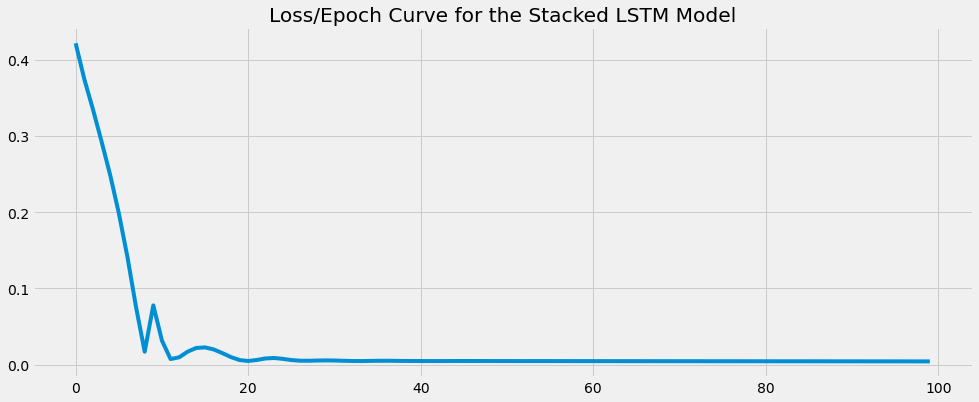

In [23]:
LPE = model.history.history['loss']

plt.figure(figsize= (15,6))
plt.plot(range(len(LPE)),LPE)
plt.title('Loss/Epoch Curve for the Stacked LSTM Model')
plt.show()

### Prediction on Train and Test Data
- This is because we need to find the performance Matrix.

In [24]:
## Predictions
ytrain_pred = model.predict(X_train)
ytest_pred = model.predict(X_test)

### Model Evaluation

In [25]:
# Accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


def forecast_accuracy(forecast, actual):
    MSE = mean_squared_error(actual, forecast)                    ## np.mean((forecast - actual)**2)             
    MAE = mean_absolute_error(actual, forecast)                        ## np.mean(np.abs(forecast - actual))    
    RMSE = sqrt(MSE)                                                       ## np.mean((forecast - actual)**2)**.5  

    print(f'Mean Squared Error:{MSE} || Mean Absolute Error:{MAE} || Root Mean Squared Error:{RMSE}')

In [26]:
## Calculating the Metrics (Train)
forecast_accuracy(y_train, ytrain_pred)

Mean Squared Error:0.004326193018660762 || Mean Absolute Error:0.05445514161138367 || Root Mean Squared Error:0.06577380191733455


In [27]:
## Calculating the Metrics (Test)
forecast_accuracy(y_test, ytest_pred)

Mean Squared Error:0.03250963065527977 || Mean Absolute Error:0.1602788720793141 || Root Mean Squared Error:0.18030427242658387


### Visualization

In [28]:
## Resetting the Index and Selecting only the Onboarding Column. (For Original Data)
df_CloseNew = df_Close.reset_index()['Close']
df_CloseNew = scaler.fit_transform(np.array(df_CloseNew).reshape(-1,1))

In [29]:
## Transform back Scaled Data to Original Data
ytrain_pred = scaler.inverse_transform(ytrain_pred)
ytest_pred = scaler.inverse_transform(ytest_pred)

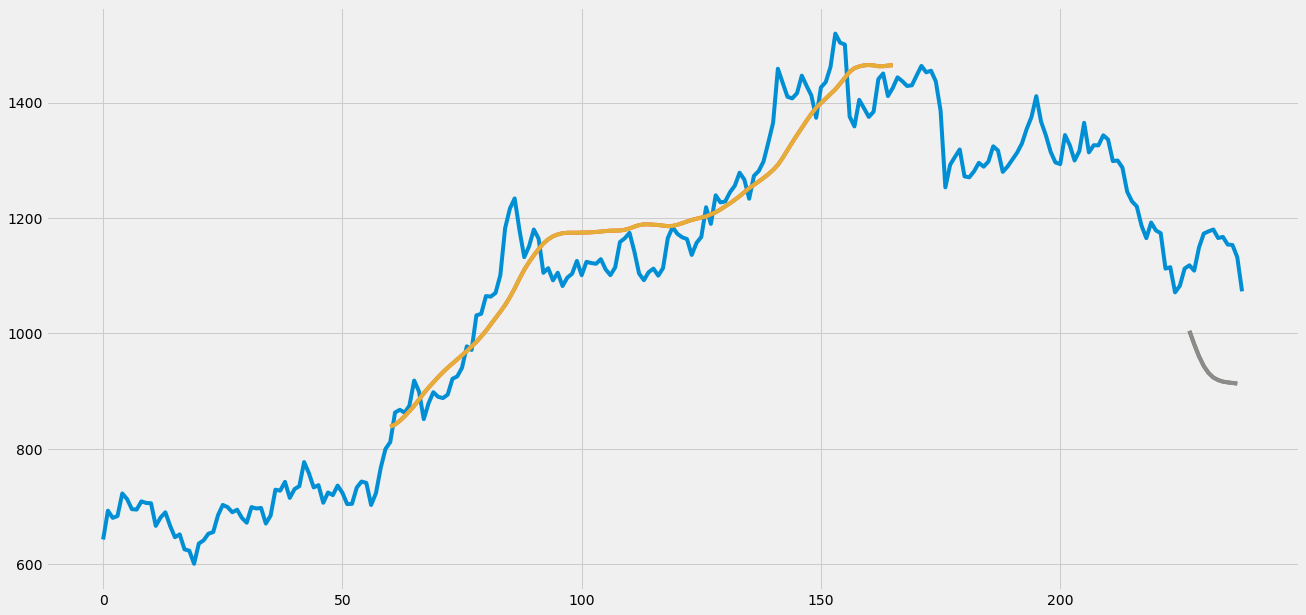

In [30]:
## Shift Train Predictions for Plotting
timestep= 60
TrainPredictPlot = np.empty_like(df_Close)
TrainPredictPlot[:, :] = np.nan
TrainPredictPlot[timestep: len(ytrain_pred) + timestep, :] = ytrain_pred         

## Shift Test Predictions for Plotting
timestep= 60
TestPredictPlot = np.empty_like(df_Close)
TestPredictPlot[:, :] = np.nan
TestPredictPlot[len(ytrain_pred) + (timestep*2) + 1:len(df_Close) - 1, :] = ytest_pred

## Baseline and Predictions Plot
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(df_CloseNew))
plt.plot(TrainPredictPlot)
plt.plot(TestPredictPlot)
plt.show()

In the above plot:

- Blue represents the Original Data.
- Yellow Represents the Predictions made on the Train Data.
- Gray Represents the Predictions made on the Test Data.

### Future Predictions

- We will now be Predicting till February 2022 and Plot the Output

In [31]:
len(test_data), X_test.shape

(72, (11, 60, 1))

In [32]:
## Selecting the Previous 60 Days to Predict the Next Day Onboarding Number
Input_data = test_data[len(test_data)-60:, :].reshape(1, -1)
Input_data.shape

(1, 60)

In [33]:
Input_data

array([[0.63097514, 0.51217342, 0.50809445, 0.5347355 , 0.57195691,
        0.55500337, 0.57782033, 0.64486953, 0.62625883, 0.53205882,
        0.55576801, 0.58623346, 0.61695347, 0.65748891, 0.72173384,
        0.77463377, 0.86641198, 0.75385615, 0.6936905 , 0.62077757,
        0.57374136, 0.56622077, 0.69458272, 0.64996832, 0.58228177,
        0.62396431, 0.74875736, 0.61810089, 0.64971344, 0.64933097,
        0.6935629 , 0.6749522 , 0.57960509, 0.58228177, 0.55079681,
        0.44423199, 0.40178483, 0.37947762, 0.29420019, 0.23926093,
        0.30809458, 0.27355016, 0.26118565, 0.10478036, 0.11102626,
        0.        , 0.02893588, 0.10503524, 0.11931179, 0.09585748,
        0.19783326, 0.25952849, 0.26934359, 0.27737425, 0.23989827,
        0.24474187, 0.21121759, 0.20905035, 0.15525819, 0.00446144]])

In [34]:
## Converting Inputs to a List
List_Input = list(Input_data)     ## Converts 2D array to a 1D array.
List_Input = List_Input[0].tolist()   ## Converts 1D array to a list.

In [35]:
df_Close.tail(1)          ### Viewing the Last Date in our Data.

,Date,Close
238,2021-12-20,1072.949951


In [36]:
### Checking the Number of days between December 21st 2021 to February 28th 2022
len(pd.date_range(start= datetime.date(2021, 12, 21), end= datetime.date(2022, 2, 28)))

70

In [37]:
## Prediction for next 70 days
output = []
n_steps = 60
i = 0

while (i<70):

  if (len(List_Input) > 60):
    Input_data = np.array(List_Input[1:])
    print(f"{i} day input {Input_data}")
    Input_data = Input_data.reshape(1, -1)
    Input_data = Input_data.reshape((1, n_steps, 1))
    ypred = model.predict(Input_data, verbose= 0)
    print(f"{i} day output {ypred}")
    
    ## Adding Predicted value inside the Previous Data so as to have the extra elements for Future Prediction.
    List_Input.extend(ypred[0].tolist())
    List_Input = List_Input[1:]

    ## Adding Predicted value inside the Output List
    output.extend(ypred.tolist())                 
    i = i + 1

  else:
    Input_data = Input_data.reshape((1, n_steps, 1))      ## Reshaping as LSTM requires 3D Data.
    ypred = model.predict(Input_data, verbose= 0)
    print(ypred[0])

    List_Input.extend(ypred[0].tolist())
    print(len(List_Input))

    output.extend(ypred.tolist())               
    i = i + 1

print(output)

[0.3309312]
61
1 day input [0.51217342 0.50809445 0.5347355  0.57195691 0.55500337 0.57782033
 0.64486953 0.62625883 0.53205882 0.55576801 0.58623346 0.61695347
 0.65748891 0.72173384 0.77463377 0.86641198 0.75385615 0.6936905
 0.62077757 0.57374136 0.56622077 0.69458272 0.64996832 0.58228177
 0.62396431 0.74875736 0.61810089 0.64971344 0.64933097 0.6935629
 0.6749522  0.57960509 0.58228177 0.55079681 0.44423199 0.40178483
 0.37947762 0.29420019 0.23926093 0.30809458 0.27355016 0.26118565
 0.10478036 0.11102626 0.         0.02893588 0.10503524 0.11931179
 0.09585748 0.19783326 0.25952849 0.26934359 0.27737425 0.23989827
 0.24474187 0.21121759 0.20905035 0.15525819 0.00446144 0.33093119]
1 day output [[0.32919452]]
2 day input [0.50809445 0.5347355  0.57195691 0.55500337 0.57782033 0.64486953
 0.62625883 0.53205882 0.55576801 0.58623346 0.61695347 0.65748891
 0.72173384 0.77463377 0.86641198 0.75385615 0.6936905  0.62077757
 0.57374136 0.56622077 0.69458272 0.64996832 0.58228177 0.62396

In [38]:
## Creating and Index for the Previous 60 and the Future 70 Days
New_Day = np.arange(1,61)
Pred_Day = np.arange(61, 131)

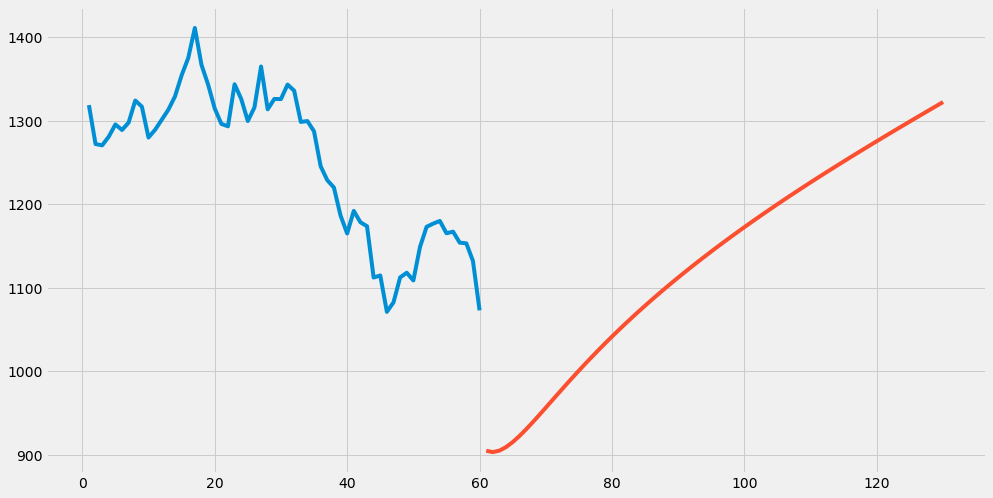

In [39]:
plot_index = len(df_CloseNew) - timestep
plt.figure(figsize= (15,8))
plt.plot(New_Day, scaler.inverse_transform(df_CloseNew[plot_index:]))    ## 275-30 = 245
plt.plot(Pred_Day, scaler.inverse_transform(output))

#### Combining the Dataframes (Forecast Based on just Training Data)

In [40]:
df_next3 = pd.DataFrame(scaler.inverse_transform(output))
df_next3['Date'] = pd.date_range(start= datetime.date(2021, 12, 21), periods= 70)
df_next3.rename(columns = {0:'Close'}, inplace = True)
df_next3            ## Getting values for all the Days.

,Close,Date
0,904.927210,2021-12-21
1,903.332251,2021-12-22
2,905.104160,2021-12-23
3,909.321700,2021-12-24
4,915.278086,2021-12-25
...,...,...
65,1303.823653,2022-02-24
66,1308.474933,2022-02-25
67,1313.112364,2022-02-26
68,1317.737752,2022-02-27


In [41]:
## Selecting only the WeekDays
required = pd.DataFrame(pd.date_range(start= datetime.date(2021,12,21), end= datetime.date(2022,2,28), freq= 'B'), columns= ['Date'])

common = df_next3.merge(required, on=["Date"])
result = df_next3[df_next3.Date.isin(common.Date)]

## Setting the Index with the correct values
result.set_index('Date', inplace= True)
result.reset_index(inplace= True)
result

,Date,Close
0,2021-12-21,904.927210
1,2021-12-22,903.332251
2,2021-12-23,905.104160
3,2021-12-24,909.321700
4,2021-12-27,930.383182
5,2021-12-28,938.843691
6,2021-12-29,947.614853
7,2021-12-30,956.551005
8,2021-12-31,965.547099
9,2022-01-03,992.224724


In [42]:
## Full Dataset
df_final = pd.concat([df_Close, result], axis=0)
df_final.set_index('Date', inplace= True)

In [43]:
pd.set_option('display.max_rows', None)
df_final.tail(51)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,904.927210
2021-12-22,903.332251
2021-12-23,905.104160
2021-12-24,909.321700
2021-12-27,930.383182
2021-12-28,938.843691
2021-12-29,947.614853
2021-12-30,956.551005


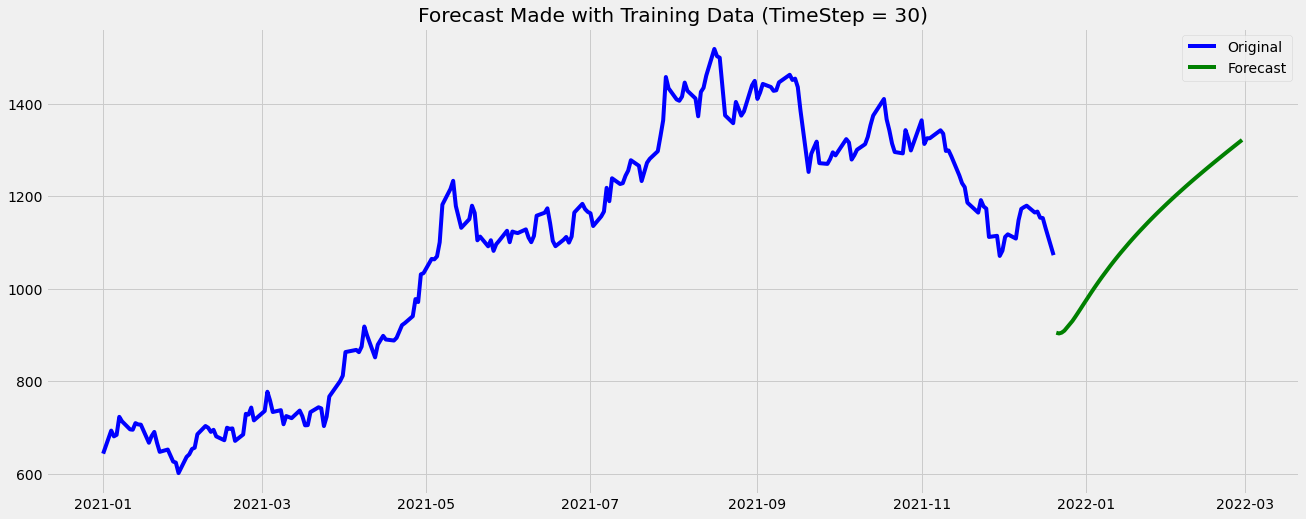

In [44]:
plt.figure(figsize=(20,8))
plt.plot(df_Close.set_index('Date'), color= 'blue', label= 'Original')
plt.plot(result.set_index('Date'), color= 'green', label= 'Forecast')
plt.legend(loc='best')
plt.title('Forecast Made with Training Data (TimeStep = 30)')
plt.show()

In [45]:
len(df_final)

289

- Looking at the pattern of our Forecast we can concur that ther trend is Increasing overtime.

---
---

<h3 align='center'>Forecast using Previous 60 Days Input (Full Dataset)</h3>

In [46]:
df_new = df.copy()
df_new.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,645.0,649.700012,640.000000,643.099976,629.023438,8411396
1,2021-01-04,649.0,699.900024,646.450012,693.000000,677.831238,38184955
2,2021-01-05,687.0,693.849976,675.099976,680.549988,665.653748,21545254
3,2021-01-06,684.0,696.650024,675.000000,683.799988,668.832581,19610522
4,2021-01-07,693.0,731.500000,691.700012,722.799988,706.978943,38232194


In [47]:
len(df_new)

239

### Feature Scaling the Full Data

In [48]:
## Resetting the Index and Selecting only the Onboarding Column.
train = df_new.reset_index()['Close']

## Feature Scaling
scaler = MinMaxScaler(feature_range= (0,1))     ## Setting the range of values to be scaled between 0 and 1.as_integer_ratio

train = scaler.fit_transform(np.array(train).reshape(-1,1))
print(train)

[[0.04584057]
 [0.10017421]
 [0.08661802]
 [0.09015678]
 [0.13262193]
 [0.12211457]
 [0.10305969]
 [0.10224305]
 [0.11775917]
 [0.11471034]
 [0.11422041]
 [0.07153747]
 [0.08721687]
 [0.09707102]
 [0.07153747]
 [0.05008711]
 [0.05547693]
 [0.02722125]
 [0.02471691]
 [0.        ]
 [0.03821861]
 [0.04426178]
 [0.05678356]
 [0.05983233]
 [0.09151784]
 [0.11100829]
 [0.1069251 ]
 [0.09717988]
 [0.10202527]
 [0.08656359]
 [0.07747171]
 [0.1069251 ]
 [0.10431183]
 [0.10534625]
 [0.07589287]
 [0.09097342]
 [0.13969946]
 [0.13795733]
 [0.15450786]
 [0.12429227]
 [0.14089723]
 [0.14645034]
 [0.19180098]
 [0.17089504]
 [0.14405486]
 [0.14835583]
 [0.1151459 ]
 [0.13447299]
 [0.12951874]
 [0.14743034]
 [0.133983  ]
 [0.11258713]
 [0.11307706]
 [0.14372822]
 [0.15516115]
 [0.15260237]
 [0.11084493]
 [0.13300307]
 [0.18058577]
 [0.21668118]
 [0.22958403]
 [0.28533317]
 [0.29045078]
 [0.28511538]
 [0.29818159]
 [0.34560106]
 [0.32502177]
 [0.27281139]
 [0.30270034]
 [0.32360628]
 [0.3149499 ]
 [0.31

In [49]:
## Obtaining X_train, and y_train based on previous 30 Days
timestep= 60
X_trainFinal, y_trainFinal = get_data(train, timestep= timestep)

In [50]:
## Viewing the training Dataset
print(X_trainFinal)
print()
print()
print(y_trainFinal)

[[0.04584057 0.10017421 0.08661802 ... 0.13300307 0.18058577 0.21668118]
 [0.10017421 0.08661802 0.09015678 ... 0.18058577 0.21668118 0.22958403]
 [0.08661802 0.09015678 0.13262193 ... 0.21668118 0.22958403 0.28533317]
 ...
 [0.85463851 0.71003915 0.75261317 ... 0.63044423 0.61443819 0.6165069 ]
 [0.71003915 0.75261317 0.76742164 ... 0.61443819 0.6165069  0.60218863]
 [0.75261317 0.76742164 0.7814677  ... 0.6165069  0.60218863 0.601263  ]]


[0.22958403 0.28533317 0.29045078 0.28511538 0.29818159 0.34560106
 0.32502177 0.27281139 0.30270034 0.32360628 0.3149499  0.31255442
 0.31903309 0.34886761 0.35344073 0.36993684 0.41022429 0.40331012
 0.46858663 0.47147211 0.50495426 0.50397426 0.51083407 0.54431621
 0.63300301 0.67002391 0.68913328 0.62951874 0.57828829 0.59870423
 0.63044423 0.61329484 0.54883497 0.55760013 0.53462542 0.54899819
 0.52390027 0.5396886  0.5471472  0.57126526 0.54431621 0.56952312
 0.56729093 0.56587537 0.57458617 0.55542243 0.54442507 0.55907005
 0.6068706  0.6138

In [51]:
print(X_trainFinal.shape), print(y_trainFinal.shape)

(178, 60)
(178,)


(None, None)

### Stacked-LSTM (Full Model)

In [52]:
## Reshape Input data to a 3-Dimensional data (i.e. (Observations, Timesteps) --> (Observations, Timesteps, Features)) 
## This process is very important before proceeding with the LSTM model.

X_trainFinal = X_trainFinal.reshape(X_trainFinal.shape[0], X_trainFinal.shape[1], 1)

In [53]:
## Create the LSTM Model
model = Sequential()

## Stacked LSTM model with 60 hidden layers.
model.add(LSTM(60, activation='relu', return_sequences= True, input_shape= (X_trainFinal.shape[1], 1)))
model.add(LSTM(60, activation='relu'))

## Output Layer
model.add(Dense(1))

## Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 60)            14880     
                                                                 
 lstm_3 (LSTM)               (None, 60)                29040     
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 43,981
Trainable params: 43,981
Non-trainable params: 0
_________________________________________________________________


In [54]:
## Compile the model
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

## Training Procedure
model.fit(X_trainFinal, y_trainFinal, epochs= 100, batch_size= 64, verbose= 1, shuffle= False)

Epoch 1/100
3/3 [==============================] - 3s 150ms/step - loss: 0.3922
Epoch 2/100
3/3 [==============================] - 0s 159ms/step - loss: 0.3225
Epoch 3/100
3/3 [==============================] - 0s 87ms/step - loss: 0.2415
Epoch 4/100
3/3 [==============================] - 0s 89ms/step - loss: 0.1400
Epoch 5/100
3/3 [==============================] - 0s 90ms/step - loss: 0.0386
Epoch 6/100
3/3 [==============================] - 0s 112ms/step - loss: 0.0925
Epoch 7/100
3/3 [==============================] - 0s 99ms/step - loss: 0.0110
Epoch 8/100
3/3 [==============================] - 0s 108ms/step - loss: 0.0309
Epoch 9/100
3/3 [==============================] - 0s 84ms/step - loss: 0.0428
Epoch 10/100
3/3 [==============================] - 0s 76ms/step - loss: 0.0382
Epoch 11/100
3/3 [==============================] - 0s 95ms/step - loss: 0.0256
Epoch 12/100
3/3 [==============================] - 0s 87ms/step - loss: 0.0133
Epoch 13/100
3/3 [===========================

### Future Forecasting (Full Model)

In [55]:
## Selecting the Previous 60 Days to Predict the Next Day Onboarding Number
Input_data = train[len(train)-60:, :].reshape(1, -1)
Input_data.shape

(1, 60)

In [56]:
## Converting Inputs to a List
List_Input = list(Input_data)     ## Converts 2D array to a 1D array.
List_Input = List_Input[0].tolist()   ## Converts 1D array to a list.

In [57]:
## Prediction for next 70 days
output = []
n_steps = 60
i = 0

while (i<70):

  if (len(List_Input) > 60):
    Input_data = np.array(List_Input[1:])
    print(f"{i} day input {Input_data}")
    Input_data = Input_data.reshape(1, -1)
    Input_data = Input_data.reshape((1, n_steps, 1))
    ypred = model.predict(Input_data, verbose= 0)
    print(f"{i} day output {ypred}")
    
    ## Adding Predicted value inside the Previous Data so as to have the extra elements for Future Prediction.
    List_Input.extend(ypred[0].tolist())
    List_Input = List_Input[1:]

    ## Adding Predicted value inside the Output List
    output.extend(ypred.tolist())                 
    i = i + 1

  else:
    Input_data = Input_data.reshape((1, n_steps, 1))      ## Reshaping as LSTM requires 3D Data.
    ypred = model.predict(Input_data, verbose= 0)
    print(ypred[0])

    List_Input.extend(ypred[0].tolist())
    print(len(List_Input))

    output.extend(ypred.tolist())               
    i = i + 1

print(output)

[0.6228377]
61
1 day input [0.73072731 0.72898517 0.7403636  0.75626092 0.74902004 0.7587652
 0.78740201 0.77945335 0.73922039 0.74934662 0.76235846 0.77547902
 0.79279176 0.82023087 0.84282451 0.88202311 0.83395035 0.80825352
 0.7771123  0.75702306 0.75381101 0.80863459 0.78957971 0.76067069
 0.77847336 0.83177265 0.77596908 0.78947085 0.7893075  0.80819902
 0.80025036 0.75952747 0.76067069 0.74722341 0.70170942 0.68358017
 0.67405274 0.63763062 0.61416598 0.64356493 0.62881096 0.62353006
 0.55672913 0.55939676 0.51197729 0.52433584 0.55683799 0.56293553
 0.55291816 0.59647216 0.62282228 0.62701433 0.63044423 0.61443819
 0.6165069  0.60218863 0.601263   0.57828829 0.51388277 0.62283772]
1 day output [[0.6236792]]
2 day input [0.72898517 0.7403636  0.75626092 0.74902004 0.7587652  0.78740201
 0.77945335 0.73922039 0.74934662 0.76235846 0.77547902 0.79279176
 0.82023087 0.84282451 0.88202311 0.83395035 0.80825352 0.7771123
 0.75702306 0.75381101 0.80863459 0.78957971 0.76067069 0.778473

#### Combining the Dataframes (Forecat Based on Full Data)

In [58]:
Forecasted = pd.DataFrame(scaler.inverse_transform(output))
Forecasted['Date'] = pd.date_range(start= datetime.date(2021, 12, 21), periods= 70)
Forecasted.rename(columns = {0:'Close'}, inplace = True)
Forecasted            ## Getting values for all the Days.

,Close,Date
0,1173.014179,2021-12-21
1,1173.787011,2021-12-22
2,1175.632875,2021-12-23
3,1178.275054,2021-12-24
4,1181.512048,2021-12-25
5,1185.176295,2021-12-26
6,1189.133953,2021-12-27
7,1193.279920,2021-12-28
8,1197.533507,2021-12-29
9,1201.833789,2021-12-30


In [59]:
## Selecting only the WeekDays
required1 = pd.DataFrame(pd.date_range(start= datetime.date(2021,12,21), end= datetime.date(2022,2,28), freq= 'B'), columns= ['Date'])

common1 = Forecasted.merge(required1, on=["Date"])
result1 = Forecasted[Forecasted.Date.isin(common1.Date)]

## Setting the Index with the correct values
result1.set_index('Date', inplace= True)
result1.reset_index(inplace= True)
result1

,Date,Close
0,2021-12-21,1173.014179
1,2021-12-22,1173.787011
2,2021-12-23,1175.632875
3,2021-12-24,1178.275054
4,2021-12-27,1189.133953
5,2021-12-28,1193.279920
6,2021-12-29,1197.533507
7,2021-12-30,1201.833789
8,2021-12-31,1206.133851
9,2022-01-03,1218.708385


In [60]:
FinalModel = pd.concat([df_new[['Date', 'Close']], result1], axis=0)
FinalModel.set_index('Date', inplace= True)
FinalModel.tail(51)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1173.014179
2021-12-22,1173.787011
2021-12-23,1175.632875
2021-12-24,1178.275054
2021-12-27,1189.133953
2021-12-28,1193.279920
2021-12-29,1197.533507
2021-12-30,1201.833789


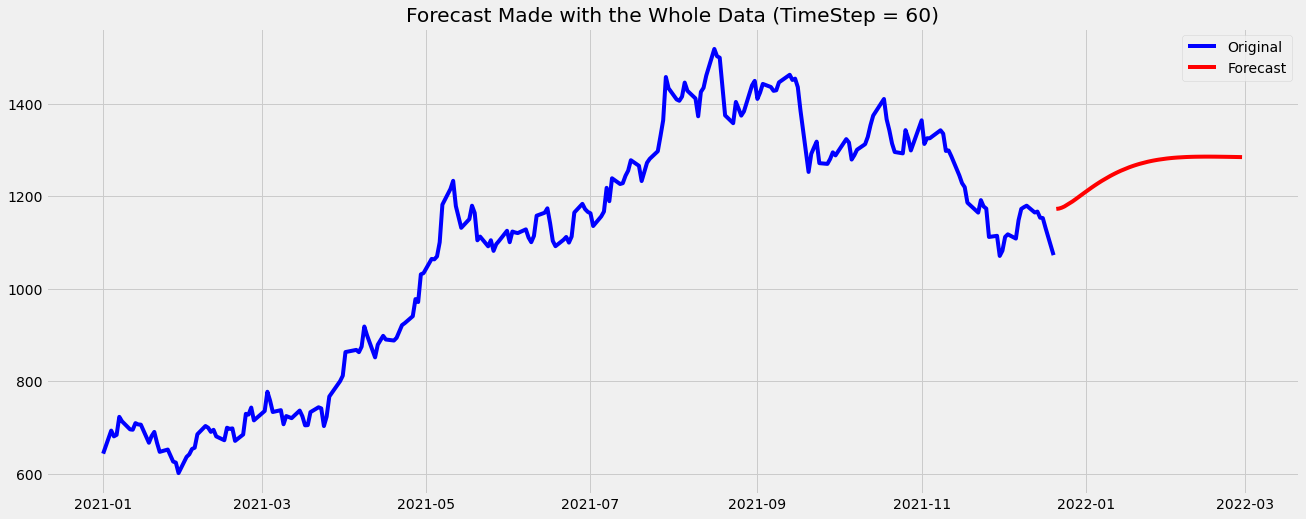

In [61]:
plt.figure(figsize=(20,8))
plt.plot(df_new[['Date', 'Close']].set_index('Date'), color= 'blue', label= 'Original')
plt.plot(result1.set_index('Date'), color= 'red', label= 'Forecast')
plt.legend(loc='best')
plt.title('Forecast Made with the Whole Data (TimeStep = 60)')
plt.show()

---
---

<h3 align='center'>Forecast using Previous Whole Days as Input (Full Dataset)</h3>

In [62]:
df_Open = df.copy()
df_Open.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,645.0,649.700012,640.000000,643.099976,629.023438,8411396
1,2021-01-04,649.0,699.900024,646.450012,693.000000,677.831238,38184955
2,2021-01-05,687.0,693.849976,675.099976,680.549988,665.653748,21545254
3,2021-01-06,684.0,696.650024,675.000000,683.799988,668.832581,19610522
4,2021-01-07,693.0,731.500000,691.700012,722.799988,706.978943,38232194


### Feature Scaling (Full Data)

In [63]:
## Resetting the Index and Selecting only the Close Price Column.
df_Open = df_Open[['Date', 'Close']]
df_Open = df_Open.reset_index()['Close']
df_Open.head()

0    643.099976
1    693.000000
2    680.549988
3    683.799988
4    722.799988
Name: Close, dtype: float64

In [64]:
df_Open = scaler.fit_transform(np.array(df_Open).reshape(-1,1))
print(df_Open)

[[0.04584057]
 [0.10017421]
 [0.08661802]
 [0.09015678]
 [0.13262193]
 [0.12211457]
 [0.10305969]
 [0.10224305]
 [0.11775917]
 [0.11471034]
 [0.11422041]
 [0.07153747]
 [0.08721687]
 [0.09707102]
 [0.07153747]
 [0.05008711]
 [0.05547693]
 [0.02722125]
 [0.02471691]
 [0.        ]
 [0.03821861]
 [0.04426178]
 [0.05678356]
 [0.05983233]
 [0.09151784]
 [0.11100829]
 [0.1069251 ]
 [0.09717988]
 [0.10202527]
 [0.08656359]
 [0.07747171]
 [0.1069251 ]
 [0.10431183]
 [0.10534625]
 [0.07589287]
 [0.09097342]
 [0.13969946]
 [0.13795733]
 [0.15450786]
 [0.12429227]
 [0.14089723]
 [0.14645034]
 [0.19180098]
 [0.17089504]
 [0.14405486]
 [0.14835583]
 [0.1151459 ]
 [0.13447299]
 [0.12951874]
 [0.14743034]
 [0.133983  ]
 [0.11258713]
 [0.11307706]
 [0.14372822]
 [0.15516115]
 [0.15260237]
 [0.11084493]
 [0.13300307]
 [0.18058577]
 [0.21668118]
 [0.22958403]
 [0.28533317]
 [0.29045078]
 [0.28511538]
 [0.29818159]
 [0.34560106]
 [0.32502177]
 [0.27281139]
 [0.30270034]
 [0.32360628]
 [0.3149499 ]
 [0.31

#### Obtaining Independent and Dependent Features

In [65]:
len(df_Open)

239

In [66]:
## Obtaining X_train and y_train based on all the previous Days
timestep= len(df_Open)-2
X_value, y_value = get_data(df_Open, timestep= timestep)

In [67]:
## Viewing the training Dataset
print(X_value)
print()
print()
print(y_value)

[[0.04584057 0.10017421 0.08661802 0.09015678 0.13262193 0.12211457
  0.10305969 0.10224305 0.11775917 0.11471034 0.11422041 0.07153747
  0.08721687 0.09707102 0.07153747 0.05008711 0.05547693 0.02722125
  0.02471691 0.         0.03821861 0.04426178 0.05678356 0.05983233
  0.09151784 0.11100829 0.1069251  0.09717988 0.10202527 0.08656359
  0.07747171 0.1069251  0.10431183 0.10534625 0.07589287 0.09097342
  0.13969946 0.13795733 0.15450786 0.12429227 0.14089723 0.14645034
  0.19180098 0.17089504 0.14405486 0.14835583 0.1151459  0.13447299
  0.12951874 0.14743034 0.133983   0.11258713 0.11307706 0.14372822
  0.15516115 0.15260237 0.11084493 0.13300307 0.18058577 0.21668118
  0.22958403 0.28533317 0.29045078 0.28511538 0.29818159 0.34560106
  0.32502177 0.27281139 0.30270034 0.32360628 0.3149499  0.31255442
  0.31903309 0.34886761 0.35344073 0.36993684 0.41022429 0.40331012
  0.46858663 0.47147211 0.50495426 0.50397426 0.51083407 0.54431621
  0.63300301 0.67002391 0.68913328 0.62951874 0.

In [68]:
print(X_value.shape), print(y_value.shape)

(1, 237)
(1,)


(None, None)

### Stacked-LSTM (Full Model)

In [69]:
## Reshape Input data to a 3-Dimensional data (i.e. (Observations, Timesteps) --> (Observations, Timesteps, Features)) 
## This process is very important before proceeding with the LSTM model.

X_value = X_value.reshape(X_value.shape[0], X_value.shape[1], 1)

In [70]:
## Create the LSTM Model
model = Sequential()

## Stacked LSTM model with 20 hidden layers.
model.add(LSTM(20, activation='relu', return_sequences= True, input_shape= (X_value.shape[1], 1)))
model.add(LSTM(20, activation='relu'))

## Output Layer
model.add(Dense(1))

## Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 237, 20)           1760      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [71]:
## Compile the model
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

## Training Procedure
model.fit(X_value, y_value, epochs= 100, batch_size= 64, verbose= 1, shuffle= False)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.4602
Epoch 2/100
1/1 [==============================] - 0s 201ms/step - loss: 0.4407
Epoch 3/100
1/1 [==============================] - 0s 211ms/step - loss: 0.4223
Epoch 4/100
1/1 [==============================] - 0s 206ms/step - loss: 0.4051
Epoch 5/100
1/1 [==============================] - 0s 194ms/step - loss: 0.3891
Epoch 6/100
1/1 [==============================] - 0s 199ms/step - loss: 0.3741
Epoch 7/100
1/1 [==============================] - 0s 256ms/step - loss: 0.3600
Epoch 8/100
1/1 [==============================] - 0s 265ms/step - loss: 0.3468
Epoch 9/100
1/1 [==============================] - 0s 192ms/step - loss: 0.3343
Epoch 10/100
1/1 [==============================] - 0s 206ms/step - loss: 0.3226
Epoch 11/100
1/1 [==============================] - 0s 358ms/step - loss: 0.3119
Epoch 12/100
1/1 [==============================] - 0s 320ms/step - loss: 0.3022
Epoch 13/100
1/1 [======================

### Future Forecasting (Full Model)

In [72]:
## Selecting the Previous 237 Days to Predict the Next Day Onboarding Number
Input_data = df_Open[len(df_Open)-237:, :].reshape(1, -1)
Input_data.shape

(1, 237)

In [73]:
## Converting Inputs to a List
List_Input = list(Input_data)     ## Converts 2D array to a 1D array.
List_Input = List_Input[0].tolist()   ## Converts 1D array to a list.

In [74]:
## Prediction for next 70 days
output = []
n_steps = 237
i = 0

while (i<70):

  if (len(List_Input) > 237):
    Input_data = np.array(List_Input[1:])
    print(f"{i} day input {Input_data}")
    Input_data = Input_data.reshape(1, -1)
    Input_data = Input_data.reshape((1, n_steps, 1))
    ypred = model.predict(Input_data, verbose= 0)
    print(f"{i} day output {ypred}")
    
    ## Adding Predicted value inside the Previous Data so as to have the extra elements for Future Prediction.
    List_Input.extend(ypred[0].tolist())
    List_Input = List_Input[1:]

    ## Adding Predicted value inside the Output List
    output.extend(ypred.tolist())                 
    i = i + 1

  else:
    Input_data = Input_data.reshape((1, n_steps, 1))      ## Reshaping as LSTM requires 3D Data.
    ypred = model.predict(Input_data, verbose= 0)
    print(ypred[0])

    List_Input.extend(ypred[0].tolist())
    print(len(List_Input))

    output.extend(ypred.tolist())               
    i = i + 1

print(output)

[0.56511664]
238
1 day input [0.09015678 0.13262193 0.12211457 0.10305969 0.10224305 0.11775917
 0.11471034 0.11422041 0.07153747 0.08721687 0.09707102 0.07153747
 0.05008711 0.05547693 0.02722125 0.02471691 0.         0.03821861
 0.04426178 0.05678356 0.05983233 0.09151784 0.11100829 0.1069251
 0.09717988 0.10202527 0.08656359 0.07747171 0.1069251  0.10431183
 0.10534625 0.07589287 0.09097342 0.13969946 0.13795733 0.15450786
 0.12429227 0.14089723 0.14645034 0.19180098 0.17089504 0.14405486
 0.14835583 0.1151459  0.13447299 0.12951874 0.14743034 0.133983
 0.11258713 0.11307706 0.14372822 0.15516115 0.15260237 0.11084493
 0.13300307 0.18058577 0.21668118 0.22958403 0.28533317 0.29045078
 0.28511538 0.29818159 0.34560106 0.32502177 0.27281139 0.30270034
 0.32360628 0.3149499  0.31255442 0.31903309 0.34886761 0.35344073
 0.36993684 0.41022429 0.40331012 0.46858663 0.47147211 0.50495426
 0.50397426 0.51083407 0.54431621 0.63300301 0.67002391 0.68913328
 0.62951874 0.57828829 0.59870423 0.

#### Combining the Dataframes (Forecat Based on Full Data)

In [75]:
OpenForecasted = pd.DataFrame(scaler.inverse_transform(output))
OpenForecasted['Date'] = pd.date_range(start= datetime.date(2021, 12, 21), periods= 70)
OpenForecasted.rename(columns = {0:'Close'}, inplace = True)
OpenForecasted            ## Getting values for all the Days.

,Close,Date
0,1120.003139,2021-12-21
1,1117.384553,2021-12-22
2,1114.782554,2021-12-23
3,1112.227029,2021-12-24
4,1109.722906,2021-12-25
5,1107.273141,2021-12-26
6,1104.879486,2021-12-27
7,1102.543144,2021-12-28
8,1100.264663,2021-12-29
9,1098.044043,2021-12-30


In [76]:
## Selecting only the WeekDays
required2 = pd.DataFrame(pd.date_range(start= datetime.date(2021,12,21), end= datetime.date(2022,2,28), freq= 'B'), columns= ['Date'])

common2 = OpenForecasted.merge(required2, on=["Date"])
result2 = OpenForecasted[OpenForecasted.Date.isin(common2.Date)]

## Setting the Index with the correct values
result2.set_index('Date', inplace= True)
result2.reset_index(inplace= True)
result2

,Date,Close
0,2021-12-21,1120.003139
1,2021-12-22,1117.384553
2,2021-12-23,1114.782554
3,2021-12-24,1112.227029
4,2021-12-27,1104.879486
5,2021-12-28,1102.543144
6,2021-12-29,1100.264663
7,2021-12-30,1098.044043
8,2021-12-31,1095.881011
9,2022-01-03,1089.731527


In [77]:
dfNew = df.copy()
dfNew = dfNew[['Date', 'Close']]

FinalModelOpen = pd.concat([dfNew, result2], axis=0)
FinalModelOpen.set_index('Date', inplace= True)
FinalModelOpen.tail(51)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1120.003139
2021-12-22,1117.384553
2021-12-23,1114.782554
2021-12-24,1112.227029
2021-12-27,1104.879486
2021-12-28,1102.543144
2021-12-29,1100.264663
2021-12-30,1098.044043


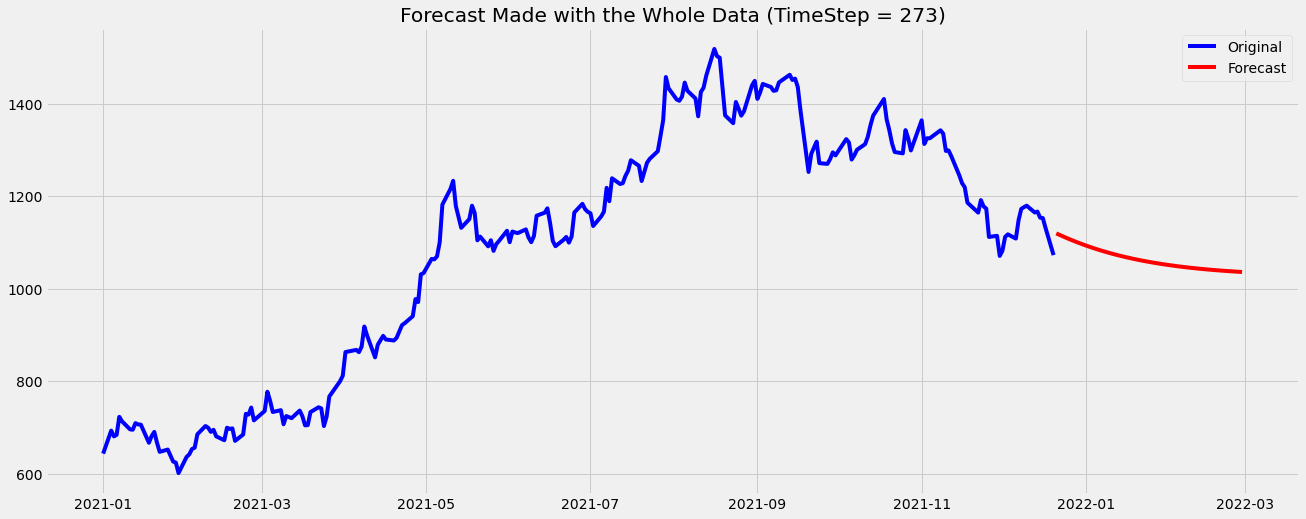

In [78]:
plt.figure(figsize=(20,8))
plt.plot(dfNew.set_index('Date'), color= 'blue', label= 'Original')
plt.plot(OpenForecasted.set_index('Date'), color= 'red', label= 'Forecast')
plt.legend(loc='best')
plt.title('Forecast Made with the Whole Data (TimeStep = 273)')
plt.show()

---
---